Repertoires of Conflict-Related Sexual Violence: Introducing the RSVAC Data Package

Last updated: January 31, 2021

In [161]:
# python: 3.6.8.final.0
# pandas: 0.23.4
# matplotlib: 3.0.2
# numpy: 1.15.4

# For data manipulation
import pandas as pd
import numpy as np

# To traverse directories and dictionaries
import itertools
import os
from collections import defaultdict

# For graphs and visualizations
import networkx as nx
from matplotlib import pyplot as plt
import matplotlib
%matplotlib inline
matplotlib.style.use('ggplot')
import seaborn as sns

# For regular expressions
import re

# Hide warnings
import warnings
warnings.filterwarnings('ignore')

# See all the text without truncation in qualitative notes
pd.options.display.max_rows
pd.set_option('display.max_colwidth', -1)

In [162]:
# Set up; point to where the dataset is saved and where to save output
rsvac_version = 'RSVAC_1989_2015_12_06_20.xlsx'
path_to_version = '/Users/logandumaine/working/RSVAC Analysis'
path_to_save = '/Users/logandumaine/working/RSVAC Analysis/'

</br>

# Load RSVAC dataset and count actors that engaged in each form 

</br>

In [163]:
# Open SVAC dataset
df_svac = pd.read_excel(os.path.join(path_to_version, rsvac_version),sheet_name=0)

# Open each sheet of the RSVAC dataset except forced pregnancy (no reports of forced pregnancy)
df_r = pd.read_excel(os.path.join(path_to_version, rsvac_version),sheet_name='rape')
df_sm = pd.read_excel(os.path.join(path_to_version, rsvac_version),sheet_name='sexual mutilation')
df_ss = pd.read_excel(os.path.join(path_to_version, rsvac_version),sheet_name='sexual slavery')
df_fp = pd.read_excel(os.path.join(path_to_version, rsvac_version),sheet_name='forced prostitution')
df_fa = pd.read_excel(os.path.join(path_to_version, rsvac_version),sheet_name='forced abortion')
df_st = pd.read_excel(os.path.join(path_to_version, rsvac_version),sheet_name='sexual torture')
df_sa = pd.read_excel(os.path.join(path_to_version, rsvac_version),sheet_name='sexual abuse')

In [164]:
# Create a dictionary to store the SVAC and RSVAC dataframes
rsvac_dic = {}

rsvac_list = [df_r, df_sm, df_ss, df_fp, df_fa, df_st, df_sa]

# Specify the list of forms. This list can be used to iterate through the dictionary of dataframes
forms = ['rape', 'sexual mutilation', 'sexual slavery','forced prostitution',
         'forced abortion', 'sexual torture', 'sexual abuse']

# Add SVAC dataframe to dictionary
rsvac_dic['svac'] = df_svac

# Add each RSVAC dataframe to dictionary
for df, form in zip(rsvac_list, forms):
    rsvac_dic[form] = df

In [165]:
# Show the keys in the RSVAC dictionary
rsvac_dic.keys()

dict_keys(['svac', 'rape', 'sexual mutilation', 'sexual slavery', 'forced prostitution', 'forced abortion', 'sexual torture', 'sexual abuse'])

##### Conflict years only

In [166]:
# Filter each dataframe so it contains active conflict years only (conflictyear = 1)
for form, key in zip(forms, rsvac_dic.items()):
    rsvac_dic[form] = rsvac_dic[form][rsvac_dic[form]['conflictyear'] == 1]

##### Remove obs where prev = 0

In [167]:
# In the state prevalence column, some observations direct users to another worksheet ('See sexual abuse tab')
# Drop these observations; they are equivalent to prev = 0
for form, key in zip(forms, rsvac_dic.items()):
     rsvac_dic[form] = rsvac_dic[form][rsvac_dic[form].iloc[:,24].isin([-99,0,1,2,3])]

In [168]:
# There are a small number of observations across the worksheets where RSVAC found no reports 
# of sexual violence (prev = 0). Remove these observations.
for form, key in zip(forms, rsvac_dic.items()):
     rsvac_dic[form] = rsvac_dic[form][(rsvac_dic[form].iloc[:,24] > 0) | 
                                       (rsvac_dic[form].iloc[:,25] > 0) | 
                                       (rsvac_dic[form].iloc[:,26] > 0)]  

##### Count the number of actors (states and rebels)

In [169]:
# Method to count actor-conflicts (states).
# Analysis includes Side A and Side B states only (actor_type = 1 or 5, respectively)
# Unit of analysis is actor-conflict; actors participating in multiple conflicts are counted once for each conflict
rsvac_dic['svac'][['actorid_new','conflictid_new']][(rsvac_dic['svac']['actor_type'] == 1) |  
                                                    (rsvac_dic['svac']['actor_type'] == 5)].drop_duplicates()[0:4]

,actorid_new,conflictid_new
0,114.0,205
233,154.0,209
260,141.0,218
282,142.0,218


In [170]:
print('Number of actor-conflicts that are states')
len(rsvac_dic['svac'][['actorid_new','conflictid_new']][(rsvac_dic['svac']['actor_type'] == 1) | 
                                                        (rsvac_dic['svac']['actor_type'] == 5)].drop_duplicates())

Number of actor-conflicts that are states


179

In [171]:
df_s_counts = len(rsvac_dic['svac'][['actorid_new','conflictid_new']][(rsvac_dic['svac']['actor_type'] == 1) | 
                                                                      (rsvac_dic['svac']['actor_type'] == 5)].drop_duplicates())

In [172]:
print('Number of actor-conflicts that are rebels')
len(rsvac_dic['svac'][['actorid_new','conflictid_new']][(rsvac_dic['svac']['actor_type'] == 3)].drop_duplicates())

Number of actor-conflicts that are rebels


367

In [173]:
df_r_counts = len(rsvac_dic['svac'][['actorid_new','conflictid_new']][(rsvac_dic['svac']['actor_type'] == 3)].drop_duplicates())

# Table of contents 

<a id='sectionTOC'></a>
<br>
[Percent of states and rebel groups reported to have perpetrated various sexual violence forms at any prevalence level](#section1)
<br>

</br>

[Co-variation in forms of sexual violence by states and by rebels](#section2)
<br>

</br>

[Collective targeting by targeted characteristic](#section3)
<br>

</br>

[Actors reported to have engaged in sexual violence at prevalence 1, 2, or 3 for each repertoire element and at prevalence 2 or 3 for each repertoire element](#section4)
<br>

</br>

[Of states/rebel actors reported to have engaged in any form at any prevalence level, the proportion reported at level 2 or 3](#section5)
<br>

</br>

[Actors reported to have engaged in sexual violence at prevalence 2 or 3 for at least three successive years, for each repertoire element](#section6)
<br>

</br>

[The proportion of actors reported to have engaged in two forms in the same year, with at least one form at the widespread (2) to massive (3) level](#section7)
<br>

</br>

[Further analysis of victim characteristics in qualitative notes](#section8)
<br>

</br>

[Observations reporting sexual violence in detention or against detainees](#section9)
<br></br>

</br>

<br>
<a id='section1'></a>

# Percent of states and rebel groups reported to have perpetrated various sexual violence forms at any prevalence level
</br>

[Back to Table of Contents](#sectionTOC)

In [174]:
# rsvac_dic_copy = RSVAC workbook
# prev_thresh = to be included in analysis, prevalence must meet this threshold
# actor_type = string of actor type for column header

# run function on reduced RSVAC worksheet: rsvac_dic_copy[form].iloc[:, [0,2,5,6,15,24,25,26]]

def count_actors_any_prev(rsvac_dic_copy, prev_thresh, actor_type):
    total_counts = []
    actors_merge_dict = {}
    
    for form_one in forms:
        df = pd.DataFrame()
        df = rsvac_dic_copy[form_one]
        all_same = []
        for index, row in df.iterrows():
            all_same.append(row[5:8].dropna().ge(prev_thresh, axis=0).any())
        df['high prev'] = all_same
        actors_merge_dict[form_one] = df
        df = df[df['high prev'] == True]
        df = df[['actorid_new','conflictid_new']]
        df.drop_duplicates(inplace=True)
        total_counts.append([form_one, len(df)])
    
    df_total = pd.DataFrame()
    df_total = pd.DataFrame(total_counts)
    df_total.columns = ['Form', actor_type]
    df_total.set_index('Form',inplace=True)    

    return df_total, actors_merge_dict

##### States 

In [175]:
# Work with a copy of the RSVAC dictionary
rsvac_dic_copy = rsvac_dic.copy()

In [176]:
# Look only at states
for form, key in zip(forms, rsvac_dic_copy.items()):
    rsvac_dic_copy[form] = rsvac_dic_copy[form][(rsvac_dic_copy[form]['actor_type'] == 1) | 
                                                (rsvac_dic_copy[form]['actor_type'] == 5)]

In [177]:
for form, key in zip(forms, rsvac_dic_copy.items()):
    rsvac_dic_copy[form] = rsvac_dic_copy[form].iloc[:, [0,2,5,6,15,24,25,26]]

In [178]:
df_states_any, states_dict_any = count_actors_any_prev(rsvac_dic_copy, 1, 'states')

df_states_any['States fraction'] = df_states_any['states']/df_s_counts

##### Rebels 

In [179]:
# Work with a copy of the RSVAC dictionary
rsvac_dic_copy = rsvac_dic.copy()

In [180]:
# Look only at rebels
for form, key in zip(forms, rsvac_dic_copy.items()):
    rsvac_dic_copy[form] = rsvac_dic_copy[form][rsvac_dic_copy[form]['actor_type'] == 3]

In [181]:
for form, key in zip(forms, rsvac_dic_copy.items()):
    rsvac_dic_copy[form] = rsvac_dic_copy[form].iloc[:, [0,2,5,6,15,24,25,26]]

In [182]:
df_rebels_any, rebels_dict_any = count_actors_any_prev(rsvac_dic_copy, 1, 'rebels')
df_rebels_any['Rebels fraction'] = df_rebels_any['rebels']/df_r_counts

##### Create table and export

In [183]:
df_total_onetwothree = df_states_any.join([df_rebels_any],how='left')

In [184]:
df_total_onetwothree.rename(index={'rape': 'Rape', 'sexual mutilation': 'Sexual mutilation', 'sexual slavery': 'Sexual slavery and forced marriage',
                                   'forced prostitution': 'Forced prostitution', 'forced abortion': 'Forced abortion and forced sterilization', 'sexual torture': 'Sexual torture', 'sexual abuse': 'Sexual abuse'},inplace=True)
df_total_onetwothree

,states,States fraction,rebels,Rebels fraction
Form,,,,
Rape,78,0.435754,68,0.185286
Sexual mutilation,8,0.044693,6,0.016349
Sexual slavery and forced marriage,10,0.055866,25,0.068120
Forced prostitution,1,0.005587,4,0.010899
Forced abortion and forced sterilization,2,0.011173,6,0.016349
Sexual torture,39,0.217877,6,0.016349
Sexual abuse,27,0.150838,18,0.049046


In [185]:
# In fraction columns, change formatting of value
df_total_onetwothree['States'] = pd.Series(["{0:.1f}".format(val * 100) for val in df_total_onetwothree['States fraction']], 
                                           index = df_total_onetwothree['States fraction'].index)
df_total_onetwothree['Rebels'] = pd.Series(["{0:.1f}".format(val * 100) for val in df_total_onetwothree['Rebels fraction']], 
                                           index = df_total_onetwothree['Rebels fraction'].index)

In [186]:
df_total_onetwothree = df_total_onetwothree[['States', 'Rebels']]
df_total_onetwothree

,States,Rebels
Form,,
Rape,43.6,18.5
Sexual mutilation,4.5,1.6
Sexual slavery and forced marriage,5.6,6.8
Forced prostitution,0.6,1.1
Forced abortion and forced sterilization,1.1,1.6
Sexual torture,21.8,1.6
Sexual abuse,15.1,4.9


In [187]:
#df_total_onetwothree.to_excel(os.path.join(path_to_save, 'rebels_states_any_prev_20200508.xlsx')

<br>
<a id='section2'></a>

# Co-variation in forms of sexual violence by states and by rebels

</br>

[Back to Table of Contents](#sectionTOC)

##### States 

In [188]:
# Work with a copy of the RSVAC dictionary
rsvac_dic_copy = rsvac_dic.copy()

In [189]:
# Look only at states
for form, key in zip(forms, rsvac_dic_copy.items()):
    rsvac_dic_copy[form] = rsvac_dic_copy[form][(rsvac_dic_copy[form]['actor_type'] == 1) |  
                                                (rsvac_dic_copy[form]['actor_type'] == 5)]

In [190]:
# Remove unnecessary columns
for form, key in zip(forms, rsvac_dic_copy.items()):
    rsvac_dic_copy[form] = rsvac_dic_copy[form].iloc[:, [0,2,5,24,25,26]]

In [191]:
# What does the dataframe look like
rsvac_dic_copy['rape'].head(1)

,year,conflictid_new,actorid_new,state_prevrape,ai_prevrape,hrw_prevrape
3,1989,209,154,0,1,0


##### Test method for finding co-variation

Create a dataframe for each form ('form DFs'). Merge two form DFs on conflict-actor-year. Use an 'inner' merge to retain only those rows where both forms have 1+ prevalence value.

In [192]:
pd.merge(rsvac_dic_copy['rape'], rsvac_dic_copy['sexual torture'], 
         how='inner',on=['year','conflictid_new','actorid_new']).head(1)

,year,conflictid_new,actorid_new,state_prevrape,ai_prevrape,hrw_prevrape,state_prevsexualtor,ai_prevsexualtor,hrw_prevsexualtor
0,1989,209,154,0,1,0,0,1.0,0.0


In [193]:
pd.merge(rsvac_dic_copy['rape'], rsvac_dic_copy['rape'], 
         how='inner',on=['year','conflictid_new','actorid_new']).head(1)

,year,conflictid_new,actorid_new,state_prevrape_x,ai_prevrape_x,hrw_prevrape_x,state_prevrape_y,ai_prevrape_y,hrw_prevrape_y
0,1989,209,154,0,1,0,0,1,0


In [194]:
# Count the states that perpetrate two forms in the same conflict and year
# rsvac_dic_copy = RSVAC workbook
# prev_thresh = to be included in analysis, prevalence must meet this threshold
# run function on reduced RSVAC worksheet: rsvac_dic_copy[form].iloc[:, [0,2,5,24,25,26]]

def count_covariation(rsvac_dic_copy, prev_thresh):
    total_counts = []
    actors_merge_dict = {}

    for form_one, key_one in zip(forms, rsvac_dic_copy.items()):
        for form_two, key_two in zip(forms, rsvac_dic_copy.items()):
            df = rsvac_dic_copy[form_one]
            df = pd.merge(df, rsvac_dic_copy[form_two], how='inner',on=['year','conflictid_new','actorid_new'])
            all_same = []
            for index, row in df.iterrows():
                all_same.append(row[3:].dropna().ge(prev_thresh, axis=0).any())
            df['meets threshold'] = all_same
            actors_merge_dict[form_one, form_two] = df
            df = df[df['meets threshold'] == True]
            df = df[['actorid_new','conflictid_new']]
            df.drop_duplicates(inplace=True)
            total_counts.append([form_one, form_two, len(df)]) 

    return pd.DataFrame(total_counts), actors_merge_dict

In [195]:
df_s_perp_same_year, states_merge_dict = count_covariation(rsvac_dic_copy, 1)
df_s_perp_same_year.columns = ['form_a', 'form_b', 'total perp same year']
df_s_perp_same_year

,form_a,form_b,total perp same year
0,rape,rape,78
1,rape,sexual mutilation,7
2,rape,sexual slavery,10
3,rape,forced prostitution,1
4,rape,forced abortion,2
5,rape,sexual torture,28
6,rape,sexual abuse,25
7,sexual mutilation,rape,7
8,sexual mutilation,sexual mutilation,8
9,sexual mutilation,sexual slavery,1


##### Create graph for states

In [196]:
df_final_states = df_s_perp_same_year

In [197]:
# Drop pairs of forms in which zero actors engaged
df_final_states_non_zero = df_final_states[df_final_states['total perp same year'] > 0]

In [198]:
# Make the graph content sentence case
df_final_states_non_zero.replace(['rape', 'sexual mutilation', 'sexual slavery','forced prostitution',
                               'forced abortion', 'sexual torture', 'sexual abuse'],
                              ['Rape','Sexual mutilation','Sexual slavery and forced marriage','Forced prostitution','Forced abortion and forced sterilization','Sexual torture','Sexual abuse'],inplace=True)

In [199]:
# Make the graph

def network_maker(df, edge_labels=False, save=None):

    # Create a node for each form of SV
    nodes = df[['form_a']][df['form_a'] == df['form_b']].values.tolist()
    
    # Set the node size according to the number of actors that engaged in the form. Multiply by a constant (150)
    # so the nodes are big enough to see
    node_calculator = df[['form_a','total perp same year']][df['form_a'] == df['form_b']].values.tolist()
    node_size = [(150*num[1]) for num in node_calculator]
    
    # Create a list of forms that will be in the graph
    forms = df['form_a'][df['form_a'] == df['form_b']].values.tolist()

    # Create the edges in the graph
    # For each pair of forms in the table, store form_a, form_b, and the count in the edge_list_labels dictionary 
    edge_list = []
    edge_widths = []
    edge_list_labels = {}
    already_seen = []
    
    for index, value in df.iterrows():
        if value[1] not in already_seen:
            already_seen.append(value[0])
            edge_list.append((value[0],value[1]))
            if value[0] == value[1]:
                pass
            else:
                edge_list_labels[(value[0],value[1])]=value[2]
            edge_widths.append(value[2]*.9)            
            
    # Format the labels on each node so that the line break follows 'and'
    labels = {}
    for lst in nodes:
        if 'and' in lst[0]:
            line_break = lst[0].split('and')
            labels[lst[0]] = (str(line_break[0] + 'and' + '\n' + line_break[1]))
        else: 
            labels[lst[0]] = (str(lst[0]))

    
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 10
    fig_size[1] = 10
    plt.rcParams["figure.figsize"] = fig_size        
            
    # Create the graph
    G = nx.Graph()
    G.add_nodes_from(forms)
    pos = nx.circular_layout(G)
    G.add_edges_from(edge_list)
    
    if edge_labels == True:
        bbox_props = dict(alpha=0)
        nx.draw_networkx_edge_labels(G,pos,edge_labels=edge_list_labels,bbox=bbox_props,label_pos=0.45)
        
    nx.draw(G,pos,with_labels=True,labels=labels,linewidths=2,width=edge_widths,
            node_size=node_size,node_color='whitesmoke',edge_color='lightgrey',font_size=12)

    # Adjust color of node perimeter
    ax = plt.gca() # to get the current axis
    ax.collections[0].set_edgecolor("gainsboro") 
    
    # Adjust spacing
    plt.subplots_adjust(left = -0.065, right = 0.75, bottom=0.2)
    plt.margins(0.1)
    
    if save is not None:
        plt.savefig(os.path.join(path_to_save, save),dpi=300,orientation='landscape',bbox_inches='tight')

    return 

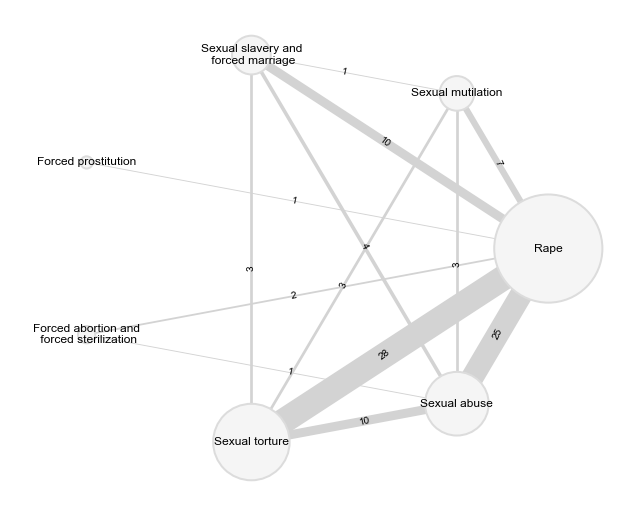

In [200]:
# Co-variation in forms of sexual violence for states
# If running in Jupyter, run this twice; graph may be compressed on the first run

x = network_maker(df_final_states_non_zero,
                  edge_labels=True,
                  save='states_network')

##### Rebels 

In [201]:
# Create a copy
rsvac_dic_copy = rsvac_dic.copy()

In [202]:
# Rebels only
for form, key in zip(forms, rsvac_dic_copy.items()):
    rsvac_dic_copy[form] = rsvac_dic_copy[form][rsvac_dic_copy[form]['actor_type'] == 3]

In [203]:
# Remove more unnecessary columns
for form, key in zip(forms, rsvac_dic_copy.items()):
    rsvac_dic_copy[form] = rsvac_dic_copy[form].iloc[:, [0,1,2,4,5,6]]

In [204]:
df_r_perp_same_year, rebels_merge_dict = count_covariation(rsvac_dic_copy, 1)
df_r_perp_same_year.columns = ['form_a', 'form_b', 'total perp same year']
df_r_perp_same_year

,form_a,form_b,total perp same year
0,rape,rape,68
1,rape,sexual mutilation,5
2,rape,sexual slavery,22
3,rape,forced prostitution,4
4,rape,forced abortion,5
5,rape,sexual torture,3
6,rape,sexual abuse,14
7,sexual mutilation,rape,5
8,sexual mutilation,sexual mutilation,6
9,sexual mutilation,sexual slavery,1


In [205]:
df_final_rebels = df_r_perp_same_year

In [206]:
# Drop pairs of forms in which zero actors engaged
df_final_rebels_non_zero = df_final_rebels[df_final_rebels['total perp same year'] > 0]

# Sentence case
df_final_rebels_non_zero.replace(['rape', 'sexual mutilation', 'sexual slavery','forced prostitution',
                                  'forced abortion', 'sexual torture', 'sexual abuse'],
                                 ['Rape','Sexual mutilation','Sexual slavery and forced marriage','Forced prostitution',
                                  'Forced abortion and forced sterilization','Sexual torture','Sexual abuse'],inplace=True)

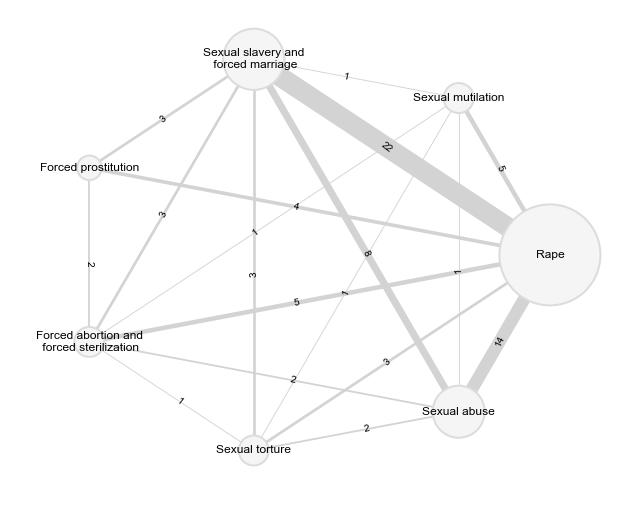

In [207]:
# Co-variation in forms of sexual violence for rebels
network_maker(df_final_rebels_non_zero,
              edge_labels=True,
              save='rebels_network')

<br>
<a id='section3'></a>

# Collective targeting by targeted characteristic
</br>

[Back to Table of Contents](#sectionTOC)

In [208]:
# Work with a copy of the RSVAC dictionary
rsvac_dic_copy = rsvac_dic.copy()

In [209]:
# Look only at states & rebels
for form, key in zip(forms, rsvac_dic_copy.items()):
    rsvac_dic_copy[form] = rsvac_dic_copy[form][(rsvac_dic_copy[form]['actor_type'] == 1) |  
                                                (rsvac_dic_copy[form]['actor_type'] == 5) |
                                                (rsvac_dic_copy[form]['actor_type'] == 3)]

In [210]:
# Remove unnecessary columns
for form, key in zip(forms, rsvac_dic_copy.items()):
    rsvac_dic_copy[form] = rsvac_dic_copy[form].iloc[:, [0,2,5,6,15,24,25,26,30]]

In [211]:
# Show retained columns
rsvac_dic_copy['rape'].head(1)

,year,conflictid_new,actorid_new,actor_type,conflictyear,state_prevrape,ai_prevrape,hrw_prevrape,Targeting notes - rape
3,1989,209,154,1,1,0,1,0,accused of being NPA members [actor] (AI Special)


In [212]:
# Table showing the fraction of observations that involved selective targeting
# Calculated for each of the 7 targeted characteristics by form of SV

df_final = pd.DataFrame()
df_final_count = pd.DataFrame()

# Store the total number of active conflict-year observations & total number of obs reporting selective targeting 

obs_list = []


# Operation

for form in forms:
    
    # count of total observations for given form of SV
    total_obs = len(rsvac_dic_copy[form])
    
    # count of observations that have reports of selective targeting
        # return list of true/false
    nonzero_obs = rsvac_dic_copy[form][rsvac_dic_copy[form].columns[8]].notna()
        # count trues
    selection_obs = np.count_nonzero(nonzero_obs)
       
    # extract selective targeting characteristics
    df = rsvac_dic_copy[form][rsvac_dic_copy[form].columns[8]].str.extractall(r'\[(.*?)\]',flags=re.IGNORECASE)
    df = df.unstack()
    
    # save results of extraction in dataframe 
    df.columns = df.columns.droplevel(0)
    
    # for the given form of SV, determine if there was a single reported characteristic or multiple
    results = []
    for index, val in df.iterrows():
        if val[0:].dropna().eq(val[0]).all() == True:
            results.append(val[0])
        else:
            results.append('multiple')
    df[form] = results
    
    df_val_counts = df[form].value_counts().transpose()
    df_val_percent = df_val_counts/selection_obs
    
    df_final = df_final.append(df_val_percent)
    df_final_count = df_final_count.append(df_val_counts)
    
    obs_list.append([form, total_obs, selection_obs])
    

In [213]:
df_final

,actor,age,ethnicity,multiple,nationality,other,rebel,religion
rape,0.321168,0.007299,0.408759,0.109489,0.051095,0.051095,0.007299,0.043796
sexual mutilation,0.666667,NaN,0.333333,NaN,NaN,NaN,NaN,NaN
sexual slavery,0.083333,0.458333,0.125000,0.166667,0.041667,0.083333,NaN,0.041667
forced prostitution,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
forced abortion,NaN,NaN,0.500000,0.250000,NaN,NaN,NaN,0.250000
sexual torture,0.800000,NaN,0.066667,0.033333,NaN,0.100000,NaN,NaN
sexual abuse,0.400000,NaN,0.100000,0.250000,0.050000,0.200000,NaN,NaN


In [214]:
df_obs = pd.DataFrame(obs_list)
df_obs.columns = ['Form','Total observations','Selective targeting observations']
df_obs.set_index('Form',inplace=True)
df_obs

,Total observations,Selective targeting observations
Form,,
rape,545,137
sexual mutilation,17,3
sexual slavery,87,24
forced prostitution,9,1
forced abortion,19,4
sexual torture,107,30
sexual abuse,107,20


In [215]:
df_final_count

,actor,age,ethnicity,multiple,nationality,other,rebel,religion
rape,44.0,1.0,56.0,15.0,7.0,7.0,1.0,6.0
sexual mutilation,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN
sexual slavery,2.0,11.0,3.0,4.0,1.0,2.0,NaN,1.0
forced prostitution,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
forced abortion,NaN,NaN,2.0,1.0,NaN,NaN,NaN,1.0
sexual torture,24.0,NaN,2.0,1.0,NaN,3.0,NaN,NaN
sexual abuse,8.0,NaN,2.0,5.0,1.0,4.0,NaN,NaN


In [216]:
# Replace null values with zero
df_final_count.fillna(0,inplace=True)
df_final.fillna(0,inplace=True)

In [217]:
# Make content sentence case
df_final.rename(index={'rape': 'Rape', 'sexual mutilation': 'Sexual mutilation', 'sexual slavery': 'Sexual slavery and forced Marriage','forced prostitution': 'Forced prostitution',
 'forced abortion': 'Forced abortion and forced sterilization', 'sexual torture': 'Sexual torture', 'sexual abuse': 'Sexual abuse'},inplace=True)

df_final_count.rename(index={'rape': 'Rape', 'sexual mutilation': 'Sexual mutilation', 'sexual slavery': 'Sexual slavery and forced Marriage','forced prostitution': 'Forced prostitution',
 'forced abortion': 'Forced abortion and forced sterilization', 'sexual torture': 'Sexual torture', 'sexual abuse': 'Sexual abuse'},inplace=True)

In [218]:
#df_obs.to_excel(os.path.join(path_to_save, 'selective_obs.xlsx'))
#df_final_count.to_excel(os.path.join(path_to_save,'count_types.xlsx'))
#df_final.to_excel(os.path.join(path_to_save,'percent_types.xlsx'))

In [219]:
# Rearrange columns
df_final = df_final[['actor','age','ethnicity','nationality','other','religion','multiple']]

In [220]:
df_final

,actor,age,ethnicity,nationality,other,religion,multiple
Rape,0.321168,0.007299,0.408759,0.051095,0.051095,0.043796,0.109489
Sexual mutilation,0.666667,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000
Sexual slavery and forced Marriage,0.083333,0.458333,0.125000,0.041667,0.083333,0.041667,0.166667
Forced prostitution,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
Forced abortion and forced sterilization,0.000000,0.000000,0.500000,0.000000,0.000000,0.250000,0.250000
Sexual torture,0.800000,0.000000,0.066667,0.000000,0.100000,0.000000,0.033333
Sexual abuse,0.400000,0.000000,0.100000,0.050000,0.200000,0.000000,0.250000


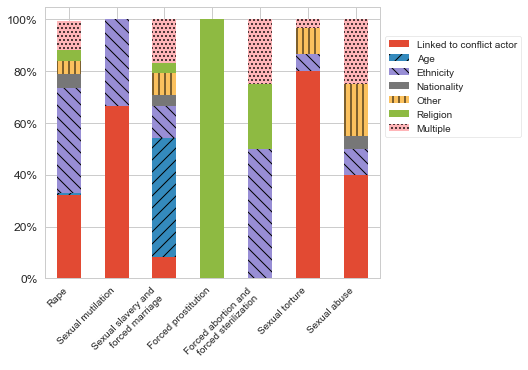

In [221]:
matplotlib.style.use('ggplot')
matplotlib.style.use('seaborn-whitegrid')

title='selective targeting figure'

fig, ax = plt.subplots(ncols=1,figsize=(10,7))

df_final.plot(kind='bar',ax=ax, stacked=True,figsize=(6,5),width=.5)

bars = ax.patches
patterns =('', '//', '\\\\','','||','','...')
hatches = [p for p in patterns for i in range(len(df_final))]
for bar, hatch in zip(bars, hatches):
    bar.set_hatch(hatch)

plt.legend(['Linked to conflict actor', 'Age', 'Ethnicity','Nationality', 'Other','Religion','Multiple'],
           loc=3, 
           bbox_to_anchor=(1, 0.5),
           markerscale=10,
           frameon=True)

x_labels = ['Rape', 'Sexual mutilation', 'Sexual slavery and\nforced marriage','Forced prostitution',
            'Forced abortion and\nforced sterilization', 'Sexual torture','Sexual abuse']

y_axis = ax.yaxis
y_axis.set_label_text('foo')
ax.set_xticklabels(list(x_labels),rotation=45,fontsize=10,ha='right')
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals],fontsize=12)
y_axis.label.set_visible(False)
x_axis = ax.xaxis
x_axis.label.set_visible(False)

plt.savefig(path_to_save+str(title)+'.png',bbox_inches='tight')


<br>
<a id='section4'></a>

# Actors reported to have engaged in sexual violence at prevalence 1, 2, or 3 for each repertoire element and at prevalence 2 or 3 for each repertoire element
</br>

[Back to Table of Contents](#sectionTOC)

In [222]:
# rsvac_dic_copy = RSVAC workbook
# prev_thresh = to be included in analysis, prevalence must meet this threshold
# actor_type = string of actor type for column header

# run function on reduced RSVAC worksheet: rsvac_dic_copy[form].iloc[:, [0,2,5,6,15,24,25,26]]

def count_actors_any_prev(rsvac_dic_copy, prev_thresh, actor_type):
    total_counts = []
    actors_merge_dict = {}
    
    for form_one in forms:
        df = pd.DataFrame()
        df = rsvac_dic_copy[form_one]
        all_same = []
        for index, row in df.iterrows():
            all_same.append(row[5:8].dropna().ge(prev_thresh, axis=0).any())
        df['high prev'] = all_same
        actors_merge_dict[form_one] = df
        df = df[df['high prev'] == True]
        df = df[['actorid_new','conflictid_new']]
        df.drop_duplicates(inplace=True)
        total_counts.append([form_one, len(df)])
    
    df_total = pd.DataFrame()
    df_total = pd.DataFrame(total_counts)
    df_total.columns = ['Form', actor_type]
    df_total.set_index('Form',inplace=True)    

    return df_total, actors_merge_dict

##### States 

In [223]:
rsvac_dic_copy = rsvac_dic.copy()

In [224]:
# Look only at states
for form, key in zip(forms, rsvac_dic_copy.items()):
    rsvac_dic_copy[form] = rsvac_dic_copy[form][(rsvac_dic_copy[form]['actor_type'] == 1) | 
                                                (rsvac_dic_copy[form]['actor_type'] == 5)]

In [225]:
for form, key in zip(forms, rsvac_dic_copy.items()):
    rsvac_dic_copy[form] = rsvac_dic_copy[form].iloc[:, [0,2,5,6,15,24,25,26]]

In [226]:
states_dict_anyprev = {}
df_states_anyprev, states_dict_anyprev = count_actors_any_prev(rsvac_dic_copy, 1, 'Count of states')

df_states_anyprev['Proportion of states'] = df_states_anyprev['Count of states']/df_s_counts

In [227]:
rsvac_dic_copy = rsvac_dic.copy()

In [228]:
# Look only at states
for form, key in zip(forms, rsvac_dic_copy.items()):
    rsvac_dic_copy[form] = rsvac_dic_copy[form][(rsvac_dic_copy[form]['actor_type'] == 1) | 
                                                (rsvac_dic_copy[form]['actor_type'] == 5)]

In [229]:
for form, key in zip(forms, rsvac_dic_copy.items()):
    rsvac_dic_copy[form] = rsvac_dic_copy[form].iloc[:, [0,2,5,6,15,24,25,26]]

In [230]:
states_dict_twothree = {}
df_states_twothree, states_dict_twothree = count_actors_any_prev(rsvac_dic_copy, 2, 'Count of states')

df_states_twothree['Proportion of states'] = df_states_twothree['Count of states']/df_s_counts

##### Rebels 

In [231]:
rsvac_dic_copy = rsvac_dic.copy()

In [232]:
for form, key in zip(forms, rsvac_dic_copy.items()):
    rsvac_dic_copy[form] = rsvac_dic_copy[form][rsvac_dic_copy[form]['actor_type'] == 3]

In [233]:
for form, key in zip(forms, rsvac_dic_copy.items()):
    rsvac_dic_copy[form] = rsvac_dic_copy[form].iloc[:, [0,2,5,6,15,24,25,26]]

In [234]:
df_rebels_anyprev, rebels_dict_anyprev = count_actors_any_prev(rsvac_dic_copy, 1, 'Count of rebels')
df_rebels_anyprev['Proportion of rebels'] = df_rebels_anyprev['Count of rebels']/df_r_counts

In [235]:
rsvac_dic_copy = rsvac_dic.copy()

In [236]:
for form, key in zip(forms, rsvac_dic_copy.items()):
    rsvac_dic_copy[form] = rsvac_dic_copy[form][rsvac_dic_copy[form]['actor_type'] == 3]

In [237]:
for form, key in zip(forms, rsvac_dic_copy.items()):
    rsvac_dic_copy[form] = rsvac_dic_copy[form].iloc[:, [0,2,5,6,15,24,25,26]]

In [238]:
df_rebels_twothree, rebels_dict_twothree = count_actors_any_prev(rsvac_dic_copy, 2, 'Count of rebels')
df_rebels_twothree['Proportion of rebels'] = df_rebels_twothree['Count of rebels']/df_r_counts

##### Create tables

In [239]:
df_total_onetwothree_table = df_states_anyprev.join([df_rebels_anyprev],how='left')

In [240]:
df_total_onetwothree_table.rename(index={'rape': 'Rape', 'sexual mutilation': 'Sexual mutilation', 'sexual slavery': 'Sexual slavery and forced marriage',
                                   'forced prostitution': 'Forced prostitution', 'forced abortion': 'Forced abortion and forced sterilization', 'sexual torture': 'Sexual torture', 'sexual abuse': 'Sexual abuse'},inplace=True)

In [241]:
df_total_onetwothree_table

,Count of states,Proportion of states,Count of rebels,Proportion of rebels
Form,,,,
Rape,78,0.435754,68,0.185286
Sexual mutilation,8,0.044693,6,0.016349
Sexual slavery and forced marriage,10,0.055866,25,0.068120
Forced prostitution,1,0.005587,4,0.010899
Forced abortion and forced sterilization,2,0.011173,6,0.016349
Sexual torture,39,0.217877,6,0.016349
Sexual abuse,27,0.150838,18,0.049046


In [242]:
#df_total_onetwothree_table.to_excel(os.path.join(path_to_save, 'rebels_states_123_prev_20210206.xlsx'))

In [243]:
df_total_twothree_table = df_states_twothree.join([df_rebels_twothree],how='left')

In [244]:
df_total_twothree_table.rename(index={'rape': 'Rape', 'sexual mutilation': 'Sexual mutilation', 'sexual slavery': 'Sexual slavery and forced marriage',
                                   'forced prostitution': 'Forced prostitution', 'forced abortion': 'Forced abortion and forced sterilization', 'sexual torture': 'Sexual torture', 'sexual abuse': 'Sexual abuse'},inplace=True)
df_total_twothree_table

,Count of states,Proportion of states,Count of rebels,Proportion of rebels
Form,,,,
Rape,41,0.229050,38,0.103542
Sexual mutilation,1,0.005587,1,0.002725
Sexual slavery and forced marriage,2,0.011173,13,0.035422
Forced prostitution,1,0.005587,2,0.005450
Forced abortion and forced sterilization,0,0.000000,2,0.005450
Sexual torture,5,0.027933,2,0.005450
Sexual abuse,6,0.033520,8,0.021798


In [245]:
#df_total_twothree_table.to_excel(os.path.join(path_to_save, 'rebels_states_23_prev_20210206.xlsx'))

<br>
<a id='section5'></a>

# Of states/rebel actors reported to have engaged in any form at any prevalence level, the proportion reported at level 2 or 3
</br>

[Back to Table of Contents](#sectionTOC)

First run the above section, Actors reported to have engaged in sexual violence at prevalence 1, 2, or 3 for each repertoire element and at prevalence 2 or 3 for each repertoire element

In [246]:
df_aggregate_states = pd.DataFrame()
for form in forms:
    df_aggregate_states = df_aggregate_states.append(states_dict_anyprev[form][['conflictid_new','actorid_new']])
count_states_anyform = len(df_aggregate_states.drop_duplicates())

In [247]:
df_aggregate_rebels = pd.DataFrame()
for form in forms:
    df_aggregate_rebels = df_aggregate_rebels.append(rebels_dict_anyprev[form][['conflictid_new','actorid_new']])
count_rebels_anyform = len(df_aggregate_rebels.drop_duplicates())

In [248]:
df_states_twothree

,Count of states,Proportion of states
Form,,
rape,41,0.229050
sexual mutilation,1,0.005587
sexual slavery,2,0.011173
forced prostitution,1,0.005587
forced abortion,0,0.000000
sexual torture,5,0.027933
sexual abuse,6,0.033520


In [249]:
df_states_twothree.columns = ['Count of states (Prev = 2 or 3)', 'Proportion of states (Prev = 2 or 3)' ]
df_states_twothree['Proportion of states'] = df_states_twothree['Count of states (Prev = 2 or 3)']/count_states_anyform
df_states_proptwothree = df_states_twothree[['Proportion of states']]

In [250]:
df_rebels_twothree.columns = ['Count of rebels (Prev = 2 or 3)', 'Proportion of rebels (Prev = 2 or 3)' ]
df_rebels_twothree['Proportion of rebels'] = df_rebels_twothree['Count of rebels (Prev = 2 or 3)']/count_rebels_anyform
df_rebels_proptwothree = df_rebels_twothree[['Proportion of rebels']]

In [251]:
df_actors_proptwothree = df_states_proptwothree.join([df_rebels_proptwothree])

In [252]:
df_actors_proptwothree.rename(index={'rape': 'Rape', 'sexual mutilation': 'Sexual mutilation', 'sexual slavery': 'Sexual slavery and forced marriage',
                                   'forced prostitution': 'Forced prostitution', 'forced abortion': 'Forced abortion and forced sterilization', 'sexual torture': 'Sexual torture', 'sexual abuse': 'Sexual abuse'},inplace=True)

df_actors_proptwothree['Proportion of states'] = pd.Series(["{0:.1f}%".format(val * 100) for val in df_actors_proptwothree['Proportion of states']], index = df_actors_proptwothree.index)
df_actors_proptwothree['Proportion of rebels'] = pd.Series(["{0:.1f}%".format(val * 100) for val in df_actors_proptwothree['Proportion of rebels']], index = df_actors_proptwothree.index)

df_actors_proptwothree

,Proportion of states,Proportion of rebels
Form,,
Rape,47.7%,52.1%
Sexual mutilation,1.2%,1.4%
Sexual slavery and forced marriage,2.3%,17.8%
Forced prostitution,1.2%,2.7%
Forced abortion and forced sterilization,0.0%,2.7%
Sexual torture,5.8%,2.7%
Sexual abuse,7.0%,11.0%


<br>
<a id='section6'></a>

# Actors reported to have engaged in sexual violence at prevalence 2 or 3 for at least three successive years, for each repertoire element
</br>

[Back to Table of Contents](#sectionTOC)

In [253]:
def three_years(actor_dict):

    results = []
    actor_dic = {}

    for form, key in zip(forms, actor_dict.items()):
        df = actor_dict[form]
        df = df[df['high prev'] == True]
        actors = df[['conflictid_new', 'actorid_new']].drop_duplicates()
        x = 0
        local_results = []
        for index, row in actors.iterrows():
            df_temp = df[(df['conflictid_new'] == row[0]) & (df['actorid_new'] == row[1])]
            df_temp['prev year'] = df_temp['year'].shift(-1) - df_temp['year']
            df_temp['prev year'] = df_temp['prev year'].shift(-1) - df_temp['prev year']

            if df_temp['prev year'].isin([0]).any():
                x+=1
                local_results.append([row[0], row[1]])
        results.append([form, x])
        actor_dic[form] = local_results
    
    return pd.DataFrame(results), actor_dic

##### States 

In [254]:
states_three_years_table, states_three_years_actor_dic = three_years(states_dict_twothree)

In [255]:
states_three_years_actor_dic

{'rape': [[283, 89],
  [287, 93],
  [297, 84],
  [299, 118],
  [309, 112],
  [337, 95],
  [364, 141],
  [416, 86],
  [11345, 113],
  [13604, 118]],
 'sexual mutilation': [],
 'sexual slavery': [],
 'forced prostitution': [],
 'forced abortion': [],
 'sexual torture': [[299, 118]],
 'sexual abuse': [[259, 116]]}

In [256]:
# Look up actor name
df_three_actors_dic = {}
for form in forms:
    df_three_actors_list = []
    for value in states_three_years_actor_dic[form]:
        find_actor = (df_svac['conflictid_new'] == value[0]) & (df_svac['actorid_new'] == value[1])
        df_three_actors_list.append(df_svac[find_actor][['actor']].drop_duplicates())
    df_three_actors_dic[form] = df_three_actors_list

In [257]:
df_three_actors_dic

{'rape': [                                     actor
  1781  Democratic Republic of Congo (Zaire),         actor
  1939  Burundi,         actor
  2465  Nigeria,       actor
  2474  Syria,       actor
  3185  Sudan,         actor
  5040  Somalia,       actor
  5702  India,                          actor
  8058  Central African Republic,             actor
  8917  South Sudan,       actor
  9242  Syria],
 'sexual mutilation': [],
 'sexual slavery': [],
 'forced prostitution': [],
 'forced abortion': [],
 'sexual torture': [      actor
  2474  Syria],
 'sexual abuse': [     actor
  1153  Iraq]}

##### Rebels

In [258]:
rebels_three_years_table, rebels_three_years_actor_dic = three_years(rebels_dict_twothree)

In [259]:
rebels_three_years_actor_dic

{'rape': [[297, 1051], [314, 488], [382, 533], [382, 532]],
 'sexual mutilation': [],
 'sexual slavery': [[297, 1051], [314, 488], [337, 717]],
 'forced prostitution': [[289, 743]],
 'forced abortion': [[289, 743]],
 'sexual torture': [],
 'sexual abuse': [[327, 567]]}

In [260]:
# Look up actor name
df_three_actors_dic_rebels = {}
for form in forms:
    df_three_actors_list = []
    for value in rebels_three_years_actor_dic[form]:
        find_actor = (df_svac['conflictid_new'] == value[0]) & (df_svac['actorid_new'] == value[1])
        df_three_actors_list.append(df_svac[find_actor][['actor']].drop_duplicates())
    df_three_actors_dic_rebels[form] = df_three_actors_list

In [261]:
df_three_actors_dic_rebels

{'rape': [                                                        actor
  2454  Jama'atu Ahlis Sunna Lidda'awati wal-Jihad (Boko Haram),      actor
  3371  LRA ,      actor
  6575  AFRC,      actor
  6612  RUF ],
 'sexual mutilation': [],
 'sexual slavery': [                                                        actor
  2454  Jama'atu Ahlis Sunna Lidda'awati wal-Jihad (Boko Haram),
       actor
  3371  LRA ,
             actor
  4960  Al-Shabaab],
 'forced prostitution': [        actor
  2270  FARC   
  2276  FARC–EP],
 'forced abortion': [        actor
  2270  FARC   
  2276  FARC–EP],
 'sexual torture': [],
 'sexual abuse': [      actor
  3732  UNITA]}

<br>
<a id='section7'></a>

# The proportion of actors reported to have engaged in two forms in the same year, with at least one form at the widespread (2) to massive (3) level

</br>

Count actors that perpetrated two forms in same conflict and year

Form A prevalence is 2 or 3
<br>
Form B prevalence is 1, 2, or 3

[Back to Table of Contents](#sectionTOC)

##### States

In [262]:
# Work with a copy of the RSVAC dictionary
rsvac_dic_copy = rsvac_dic.copy()

In [263]:
# Look only at states
for form, key in zip(forms, rsvac_dic_copy.items()):
    rsvac_dic_copy[form] = rsvac_dic_copy[form][(rsvac_dic_copy[form]['actor_type'] == 1) |  
                                                (rsvac_dic_copy[form]['actor_type'] == 5)]

In [264]:
# Remove unnecessary columns
for form, key in zip(forms, rsvac_dic_copy.items()):
    rsvac_dic_copy[form] = rsvac_dic_copy[form].iloc[:, [0,2,5,24,25,26]]

In [265]:
# Count the states that perpetrate two forms in the same conflict and year with one form at prev = 2 or 3
# rsvac_dic_copy = RSVAC workbook
# prev_thresh_oneform = to be included in analysis, prevalence of one form must meet this threshold
# run function on reduced RSVAC worksheet: rsvac_dic_copy[form].iloc[:, [0,1,2,4,5,6]]


def count_covariation_high(rsvac_dic_copy, prev_thresh_oneform):
    total_counts = []
    actors_merge_dict = {}

    for form_one, key_one in zip(forms, rsvac_dic_copy.items()):
        for form_two, key_two in zip(forms, rsvac_dic_copy.items()):

            df = rsvac_dic_copy[form_one]
            df = pd.merge(df, rsvac_dic_copy[form_two], how='inner',on=['year','conflictid_new','actorid_new'])
            all_same = []
            for index, row in df.iterrows():
                all_same.append(row[3:6].dropna().ge(prev_thresh_oneform, axis=0).any())
            df['meets threshold'] = all_same
            actors_merge_dict[form_one, form_two] = df
            df = df[df['meets threshold'] == True]
            df = df[['actorid_new','conflictid_new']]
            df.drop_duplicates(inplace=True)
            total_counts.append([form_one, form_two, len(df)])  
            
    return pd.DataFrame(total_counts), actors_merge_dict

In [266]:
states_perp_same_year_onehigh, states_perp_same_year_onehigh_dic = count_covariation_high(rsvac_dic_copy, 2)
states_perp_same_year_onehigh.columns = ['Form A (Prev 2|3)', 'Form B (Prev 1|2|3)', 'States']
states_perp_same_year_onehigh

,Form A (Prev 2|3),Form B (Prev 1|2|3),States
0,rape,rape,41
1,rape,sexual mutilation,4
2,rape,sexual slavery,7
3,rape,forced prostitution,1
4,rape,forced abortion,1
5,rape,sexual torture,10
6,rape,sexual abuse,12
7,sexual mutilation,rape,1
8,sexual mutilation,sexual mutilation,1
9,sexual mutilation,sexual slavery,0


##### Rebels

In [267]:
# Work with a copy of the RSVAC dictionary
rsvac_dic_copy = rsvac_dic.copy()

In [268]:
# Look only at rebels
for form, key in zip(forms, rsvac_dic_copy.items()):
    rsvac_dic_copy[form] = rsvac_dic_copy[form][rsvac_dic_copy[form]['actor_type'] == 3]

In [269]:
# Remove unnecessary columns
for form, key in zip(forms, rsvac_dic_copy.items()):
    rsvac_dic_copy[form] = rsvac_dic_copy[form].iloc[:, [0,2,5,24,25,26]]

In [270]:
rebels_perp_same_year_onehigh, rebels_perp_same_year_onehigh_dic = count_covariation_high(rsvac_dic_copy, 2)
rebels_perp_same_year_onehigh.columns = ['Form A (Prev 2|3)', 'Form B (Prev 1|2|3)', 'Rebels']
rebels_perp_same_year_onehigh

,Form A (Prev 2|3),Form B (Prev 1|2|3),Rebels
0,rape,rape,38
1,rape,sexual mutilation,3
2,rape,sexual slavery,16
3,rape,forced prostitution,2
4,rape,forced abortion,3
5,rape,sexual torture,3
6,rape,sexual abuse,12
7,sexual mutilation,rape,0
8,sexual mutilation,sexual mutilation,1
9,sexual mutilation,sexual slavery,0


In [271]:
states_perp_same_year_onehigh['Proportion of states'] = states_perp_same_year_onehigh['States']/df_s_counts
rebels_perp_same_year_onehigh['Proportion of rebels'] = rebels_perp_same_year_onehigh['Rebels']/df_r_counts

In [272]:
states_rebels_perp_same_year_onehigh = pd.merge(rebels_perp_same_year_onehigh,
                                                states_perp_same_year_onehigh,on=['Form A (Prev 2|3)', 'Form B (Prev 1|2|3)'],how='outer')

In [273]:
states_rebels_perp_same_year_onehigh = states_rebels_perp_same_year_onehigh[states_rebels_perp_same_year_onehigh['Form A (Prev 2|3)']
                                                                            != states_rebels_perp_same_year_onehigh['Form B (Prev 1|2|3)']]

In [274]:
states_rebels_perp_same_year_onehigh = states_rebels_perp_same_year_onehigh[(states_rebels_perp_same_year_onehigh['Rebels'] > 0) |
                                                                            (states_rebels_perp_same_year_onehigh['States'] > 0)]

In [275]:
states_rebels_perp_same_year_onehigh['Proportion of states'] = pd.Series(["{0:.1f}%".format(val * 100) for val in states_rebels_perp_same_year_onehigh['Proportion of states']], index = states_rebels_perp_same_year_onehigh.index)
states_rebels_perp_same_year_onehigh['Proportion of rebels'] = pd.Series(["{0:.1f}%".format(val * 100) for val in states_rebels_perp_same_year_onehigh['Proportion of rebels']], index = states_rebels_perp_same_year_onehigh.index)

In [276]:
states_rebels_perp_same_year_onehigh.replace(['rape', 'sexual mutilation', 'sexual slavery','forced prostitution','forced abortion', 'sexual torture', 'sexual abuse'],
                                             ['Rape','Sexual mutilation','Sexual slavery and forced marriage','Forced prostitution','Forced abortion and forced sterilization','Sexual torture','Sexual abuse'],inplace=True)

In [277]:
states_rebels_perp_same_year_onehigh.set_index(['Form A (Prev 2|3)', 'Form B (Prev 1|2|3)'],inplace=True)

In [278]:
states_rebels_perp_same_year_onehigh

Rebels  \
Form A (Prev 2|3)                        Form B (Prev 1|2|3)                                
Rape                                     Sexual mutilation                         3        
                                         Sexual slavery and forced marriage        16       
                                         Forced prostitution                       2        
                                         Forced abortion and forced sterilization  3        
                                         Sexual torture                            3        
                                         Sexual abuse                              12       
Sexual mutilation                        Rape                                      0        
                                         Sexual abuse                              1        
Sexual slavery and forced marriage       Rape                                      13       
                                         Sexual mutilation                         0        
                                         Forced prostitution                       1        
                                         Forced abortion and forced sterilization  2        
                                         Sexual torture                            2        
                                         Sexual abuse                              8        
Forced prostitution                      Rape                                      2        
                                         Sexual slavery and forced marriage        1        
                                         Forced abortion and forced sterilization  2        
Forced abortion and forced sterilization Rape                                      2        
                                         Sexual slavery and forced marriage        2        
                                         Forced prostitution                       1        
                                         Sexual abuse                              1        
Sexual torture                           Rape                                      2        
                                         Sexual mutilation                         0        
                                         Sexual slavery and forced marriage        2        
                                         Sexual abuse                              2        
Sexual abuse                             Rape                                      7        
                                         Sexual mutilation                         1        
                                         Sexual slavery and forced marriage        7        
                                         Forced abortion and forced sterilization  2        
                                         Sexual torture                            2        

                                                                                  Proportion of rebels  \
Form A (Prev 2|3)                        Form B (Prev 1|2|3)                                             
Rape                                     Sexual mutilation                         0.8%                  
                                         Sexual slavery and forced marriage        4.4%                  
                                         Forced prostitution                       0.5%                  
                                         Forced abortion and forced sterilization  0.8%                  
                                         Sexual torture                            0.8%                  
                                         Sexual abuse                              3.3%                  
Sexual mutilation                        Rape                                      0.0%                  
                                         Sexual abuse                              0.3%                  
Sexual slavery and forced marriage       Rape 

In [279]:
#states_rebels_perp_same_year_onehigh.to_excel((os.path.join(path_to_save, 'section_one_three_20210207.xlsx')))

<br>
<a id='section8'></a>

# Further analysis of victim characteristics in qualitative notes

</br>

[Back to Table of Contents](#sectionTOC)

In [280]:
rsvac_dic_copy = rsvac_dic.copy()

In [281]:
for form, key in zip(forms, rsvac_dic_copy.items()):
    rsvac_dic_copy[form] = rsvac_dic_copy[form].iloc[:, [0,2,5,6,15,24,25,26,29]]

In [282]:
for form, key in zip(forms, rsvac_dic_copy.items()):
    rsvac_dic_copy[form] = rsvac_dic_copy[form][(rsvac_dic_copy[form]['actor_type'] == 1) | 
                                                (rsvac_dic_copy[form]['actor_type'] == 5) |
                                                (rsvac_dic_copy[form]['actor_type'] == 3)]

In [283]:
# validate
rsvac_dic_copy['rape']['actor_type'].value_counts()

1    363
3    179
5    3  
Name: actor_type, dtype: int64

In [284]:
#The number of conflicts in which rape was reported
rsvac_dic_copy['rape']['conflictid_new'].nunique()

86

In [285]:
rsvac_dic_copy['rape']['Victim Child'] = rsvac_dic_copy['rape']['Victim notes - rape'].str.extract(r'([Cc]hild|[Gg]irl|[Bb]oy| [Gg]irl| [Cc]hild)')

In [286]:
rsvac_dic_copy['rape'][rsvac_dic_copy['rape']['Victim Child'].notnull()]

,year,conflictid_new,actorid_new,actor_type,conflictyear,state_prevrape,ai_prevrape,hrw_prevrape,Victim notes - rape,Victim Child
18,2007,221,144,1,1,1,0,0,child,child
19,2008,221,144,1,1,1,0,1,child,child
20,2009,221,144,1,1,1,0,0,child,child
35,2011,227,141,1,1,1,0,2,girl (State),girl
37,2015,227,141,1,1,1,0,0,girl,girl
38,2011,231,144,1,1,3,1,2,detainee (AI); girls (HRW),girl
44,1994,233,11,1,1,1,1,0,child,child
45,2010,234,121,1,1,2,0,0,children,child
47,1997,251,141,1,1,1,0,0,child,child
54,2014,259,234,3,1,2,3,0,girl,girl


In [287]:
#Export to review whether regex captured everything
#rsvac_dic_copy['rape'].to_excel(os.path.join(path_to_save,'RSVAC_R_Child_20200516.xlsx'),index=False)

In [288]:
rsvac_dic_copy['rape']['conflictid_new'][rsvac_dic_copy['rape']['Victim Child'].notnull()].nunique()

53

In [289]:
#Children were reported as victims of rape in the following percent of conflicts in which rape was reported
100*(53/86)

61.627906976744185

In [290]:
#The number of conflicts in which forced prostitution was reported
rsvac_dic_copy['forced prostitution']['conflictid_new'].nunique()

4

In [291]:
rsvac_dic_copy['forced prostitution']['Victim Child'] = rsvac_dic_copy['forced prostitution']['Victim notes - forced prostitution'].str.extract(r'([Cc]hild|[Gg]irl|[Bb]oy| [Gg]irl| [Cc]hild)')


In [292]:
rsvac_dic_copy['forced prostitution']

,year,conflictid_new,actorid_new,actor_type,conflictyear,state_prevforcedpros,ai_prevforcedpros,hrw_prevforcedpros,Victim notes - forced prostitution,Victim Child
0,2010,289,744,3,1,3,0,0,children,child
3,2013,289,744,3,1,3,0,0,children,child
6,2010,289,743,3,1,3,0,0,children,child
7,2011,289,743,3,1,3,0,0,children,child
8,2012,289,743,3,1,3,0,0,children,child
9,2013,289,743,3,1,3,0,0,children,child
18,2006,364,141,1,1,2,0,0,Girls [child],Girl
19,2012,372,1158,3,1,1,0,0,NaN,NaN
20,1993,389,339,3,1,1,0,0,Detainee (State),NaN


In [293]:
#The number of conflicts in which children were reported as victims of forced prostitution
rsvac_dic_copy['forced prostitution']['conflictid_new'][rsvac_dic_copy['forced prostitution']['Victim Child'].notnull()].nunique()

2

In [294]:
#The number of observations on the sexual torture tab
len(rsvac_dic_copy['sexual torture'])

107

In [295]:
rsvac_dic_copy['sexual torture']['Victim Sex'] = rsvac_dic_copy['sexual torture']['Victim notes - sexual torture'].str.extract(
    r'([Ff]emale \(\d\)|[Mm]ale \(\d\)|GNS|M/F \(\d\))')

In [296]:
# Export to review whether regex captured everything

#rsvac_dic_copy['sexual torture'].to_excel(os.path.join(path_to_save,'RSVAC_ST_MorF_20200516.xlsx'),index=False)

# Required some edits to capture things the regex missed

In [297]:
df_st_mf = pd.read_excel(os.path.join(path_to_version, 'RSVAC_ST_MorF_20200516.xlsx'))

In [298]:
df_st_mf['Victim Sex'].value_counts()

Male (1)      72
Female (1)    11
GNS           7 
M/F (1)       6 
Male (2)      5 
M/F (2)       1 
Name: Victim Sex, dtype: int64

In [299]:
#observations in which reports included male victims
100*((72+6+5+1)/107)

78.50467289719626

In [300]:
#observations in which reports included female victims
100*((11+6+1)/107)

16.822429906542055

<br>
<a id='section9'></a>

# Observations reporting sexual violence in detention or against detainees

</br>

[Back to Table of Contents](#sectionTOC)

Reloading the dataset because I want to access all observations, including interim and post-conflict years and all rebels, states, and militias

In [301]:
# Open SVAC dataset
df_svac = pd.read_excel(os.path.join(path_to_version, rsvac_version),sheet_name=0)

# Open each sheet of the RSVAC dataset except forced pregnancy (no reports of forced pregnancy)
df_r = pd.read_excel(os.path.join(path_to_version, rsvac_version),sheet_name='rape')
df_sm = pd.read_excel(os.path.join(path_to_version, rsvac_version),sheet_name='sexual mutilation')
df_ss = pd.read_excel(os.path.join(path_to_version, rsvac_version),sheet_name='sexual slavery')
df_fp = pd.read_excel(os.path.join(path_to_version, rsvac_version),sheet_name='forced prostitution')
df_fa = pd.read_excel(os.path.join(path_to_version, rsvac_version),sheet_name='forced abortion')
df_st = pd.read_excel(os.path.join(path_to_version, rsvac_version),sheet_name='sexual torture')
df_sa = pd.read_excel(os.path.join(path_to_version, rsvac_version),sheet_name='sexual abuse')

In [302]:
# Create a dictionary to store the SVAC and RSVAC dataframes
rsvac_dic = {}

rsvac_list = [df_r, df_sm, df_ss, df_fp, df_fa, df_st, df_sa]

# Specify the list of forms. This list can be used to iterate through the dictionary of dataframes
forms = ['rape', 'sexual mutilation', 'sexual slavery','forced prostitution',
         'forced abortion', 'sexual torture', 'sexual abuse']

# Add SVAC dataframe to dictionary
rsvac_dic['svac'] = df_svac

# Add each RSVAC dataframe to dictionary
for df, form in zip(rsvac_list, forms):
    rsvac_dic[form] = df

In [303]:
# Show the keys in the RSVAC dictionary
rsvac_dic.keys()

dict_keys(['svac', 'rape', 'sexual mutilation', 'sexual slavery', 'forced prostitution', 'forced abortion', 'sexual torture', 'sexual abuse'])

##### Remove obs where prev = 0

In [304]:
# In the state prevalence column, some observations direct users to another worksheet ('See sexual abuse tab')
# Drop these observations; they are equivalent to prev = 0
for form, key in zip(forms, rsvac_dic.items()):
     rsvac_dic[form] = rsvac_dic[form][rsvac_dic[form].iloc[:,24].isin([-99,0,1,2,3])]

In [305]:
# There are a small number of observations across the worksheets where RSVAC found no reports 
# of sexual violence (prev = 0). Remove these observations.
for form, key in zip(forms, rsvac_dic.items()):
     rsvac_dic[form] = rsvac_dic[form][(rsvac_dic[form].iloc[:,24] > 0) | 
                                       (rsvac_dic[form].iloc[:,25] > 0) | 
                                       (rsvac_dic[form].iloc[:,26] > 0)]  

In [306]:
rsvac_dic_copy = rsvac_dic.copy()

In [307]:
for form, key in zip(forms, rsvac_dic_copy.items()):
    rsvac_dic_copy[form] = rsvac_dic_copy[form].iloc[:, [0,2,5,6,24,25,26,29,32]]

In [308]:
# Show the columns that I retained
rsvac_dic_copy['rape'].head()

,year,conflictid_new,actorid_new,actor_type,state_prevrape,ai_prevrape,hrw_prevrape,Victim notes - rape,Location notes - rape
0,1989,209,8137,6,0,1,0,detainee,Northern Samar
1,1991,209,8137,6,0,1,0,NaN,"Bayombong, Nueva Vizcaya; had entered her home"
2,1993,209,8137,6,0,1,0,child,"in Rizal, Occidental Mindoro"
3,1989,209,154,1,0,1,0,NaN,Northern Samar (AI Special)
4,1990,209,154,1,0,1,0,Detainee (AI Special),176th PC Company headquarters in Morong [detention] (AI Special); a military camp [camp] (AI Special); detention (AI Special)


In [309]:
# Find victim = detainee
for form, key in zip(forms, rsvac_dic_copy.items()):
    rsvac_dic_copy[form]['Victim Detainee'] = rsvac_dic_copy[form].iloc[:,7].str.contains(r'detain',flags=re.IGNORECASE)

In [310]:
rsvac_dic_copy['sexual slavery']

,year,conflictid_new,actorid_new,actor_type,state_prevsexualslav,ai_prevsexualslav,hrw_prevsexualslav,Victim notes - sexual slavery,Location notes - sexual slavery,Victim Detainee
0,2011,231,144,1,0,0,1,NaN,Light Infantry Battalion 301’s Mu Bum Burmese army post near the China border [place of captivity] (HRW),NaN
1,2014,259,234,3,3,3,2,FM/SS; girls; detainee,Sinjar District of Ninewa [place of capture]; Mosul and Tal ‘Afar [place of captivity],True
2,2015,259,234,3,3,1,3,FM/SS; girls,areas under IS control,False
3,2008,283,89,1,1,0,1,Child (HRW Special),"Camp (HRW Special); Gemena, Equateur Province (State); private home (State)",False
4,2009,283,89,1,1,0,1,FM/SS; Child (HRW),Busurungi (State); army position (HRW Special); at a camp (HRW Special),False
6,2011,283,89,1,1,0,0,detainee (State),in the East (State),True
7,2012,283,89,1,1,0,0,detainee (State),in the East (State),True
8,2013,283,89,1,2,0,0,NaN,in the East,NaN
9,2005,283,528,6,1,0,0,FM; Girl [child] (State),the South Kivu Province village of Kabingu (place of abduction) (State),False
10,2009,283,528,6,2,0,2,FM/SS; Girls [child] (HRW),FDLR Camps (place of captivity) (State); bush (place of captivity) (HRW); Kinono forest (HRW),False


In [311]:
# Find location = detention
for form, key in zip(forms, rsvac_dic_copy.items()):
    rsvac_dic_copy[form]['Location Detention'] = rsvac_dic_copy[form].iloc[:,8].str.contains(r'detent',flags=re.IGNORECASE)

In [312]:
# Count observations where location = detention and/or victim = detainee

counts = []
for form, key in zip(forms, rsvac_dic_copy.items()):
    total = len(rsvac_dic_copy[form])
    loc_det_count = len(rsvac_dic_copy[form][rsvac_dic_copy[form]['Location Detention'] == True]) 
    loc_det = len(rsvac_dic_copy[form][rsvac_dic_copy[form]['Location Detention'] == True])/total
    vic_det_count = len(rsvac_dic_copy[form][rsvac_dic_copy[form]['Victim Detainee'] == True])
    vic_det = len(rsvac_dic_copy[form][rsvac_dic_copy[form]['Victim Detainee'] == True])/total
    counts.append([form, loc_det_count, loc_det, vic_det_count, vic_det])
df = pd.DataFrame(counts)
df.columns = ['Form', 'Location detention: Count of observations', 'Location detention: Proportion of total observations',
              'Victim detainee: Count of observations', 'Victim detainee: Proportion of total observations']

In [313]:
df

,Form,Location detention: Count of observations,Location detention: Proportion of total observations,Victim detainee: Count of observations,Victim detainee: Proportion of total observations
0,rape,62,0.074519,203,0.243990
1,sexual mutilation,1,0.040000,7,0.280000
2,sexual slavery,5,0.039370,54,0.425197
3,forced prostitution,0,0.000000,1,0.058824
4,forced abortion,0,0.000000,2,0.086957
5,sexual torture,67,0.496296,110,0.814815
6,sexual abuse,30,0.215827,62,0.446043
